In [1]:
import os
import time
import numpy as np

import mindspore
from mindspore.common import set_seed
from mindspore import nn, Tensor, context, ops, jit
from mindspore.train.serialization import load_param_into_net

In [2]:
from mindflow.cell import PDENet
from mindflow.utils import load_yaml_config
from mindflow.loss import get_loss_metric, RelativeRMSELoss
from mindflow.pde import UnsteadyFlowWithLoss

from src import init_model, create_dataset, calculate_lp_loss_error
from src import make_dir, scheduler, get_param_dic,get_param_dic_frozen
from src import plot_coe,plot_coe_label, plot_extrapolation_error, get_label_coe, plot_test_error,plot_test_error_0

In [3]:
set_seed(0)
np.random.seed(0)
context.set_context(mode=context.GRAPH_MODE, device_target="GPU", device_id=0)

In [4]:
# load configuration yaml
config = load_yaml_config('pde_net.yaml')

In [5]:
def init_model(config,kernel_size,if_frozen):
    return PDENet(height=config["mesh_size"],
                  width=config["mesh_size"],
                  channels=config["channels"],
                  kernel_size=kernel_size,
                  max_order=config["max_order"],
                  dx=2 * np.pi / config["mesh_size"],
                  dy=2 * np.pi / config["mesh_size"],
                  dt=config["dt"],
                  periodic=config["perodic_padding"],
                  enable_moment=config["enable_moment"],
                  if_fronzen=if_frozen,
                  )

## 模型推理及可视化

1.  定义变量 `step` 并赋值为 `20`。
2.  定义变量 `test_data_size` 并赋值为 `20`。
3.  初始化 `model_5`:
    * 调用 `init_model` 函数，传入 `config`、`5`（可能代表 `kernel_size` 或其他配置参数）和 `False`（可能代表 `if_fronzen`）。
    * 调用 `get_param_dic` 函数加载路径为 `"./summary_dir/summary_kernel_5"`，`current_step` 为 `config["multi_step"]`，`epochs` 为 `config["epochs"]` 的参数字典，并将其赋值给 `param_dict_5`。
    * 调用 `load_param_into_net` 函数将 `param_dict_5` 中的参数加载到 `model_5` 中。
4.  同理初始化 `model_7`，`model_5_frozen`,`model_7_frozen`:

In [6]:
step = 20
test_data_size = 20

model_5 = init_model(config,5,False)
param_dict_5 = get_param_dic("./summary_dir/summary_kernel_5", config["multi_step"], config["epochs"])
load_param_into_net(model_5, param_dict_5)

model_7 = init_model(config,7,False)
param_dict_7 = get_param_dic("./summary_dir/summary_kernel_7", config["multi_step"], config["epochs"])
print(param_dict_7)
load_param_into_net(model_7, param_dict_7)


{'moment': Parameter (name=moment, shape=(15, 7, 7), dtype=Float32, requires_grad=True), 'coe_param': Parameter (name=coe_param, shape=(14, 50, 50), dtype=Float32, requires_grad=True)}


([], [])

In [7]:
model_5_frozen = init_model(config,5,True)
param_dict_5_frozen = get_param_dic("./summary_dir/summary_kernel_5_frozen", config["multi_step"], config["epochs"])
load_param_into_net(model_5_frozen, param_dict_5_frozen)
print(param_dict_5_frozen)
model_7_frozen = init_model(config,7,True)
param_dict_7_frozen = get_param_dic("./summary_dir/summary_kernel_7_frozen", config["multi_step"], config["epochs"])
load_param_into_net(model_7_frozen, param_dict_7_frozen)


{'moment': Parameter (name=moment, shape=(15, 5, 5), dtype=Float32, requires_grad=True), 'coe_param': Parameter (name=coe_param, shape=(14, 50, 50), dtype=Float32, requires_grad=True)}


([], [])

### Plot Coefficient
下图展示了PDE中导数系数的预测结果和真实标签的对比情况。
- 第一行为kernel_size=5的情况
- 第二行为kernel_size=7的情况
- 第三行为真实系数

6


/home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/src/utils.py:147: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, pad=0.2, w_pad=0.2, h_pad=0.2)


6
6


/home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/src/utils.py:192: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  gs.tight_layout(fig, pad=0.2, w_pad=0.2, h_pad=0.2)


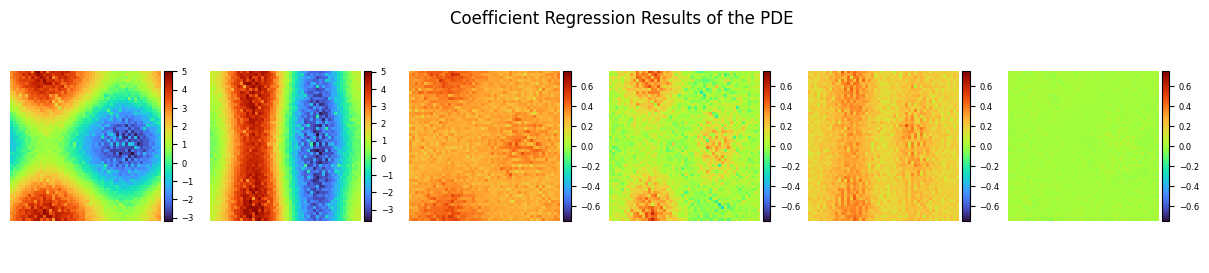

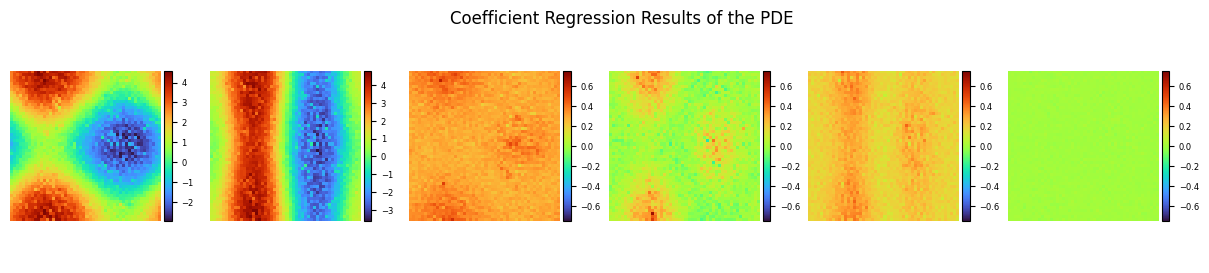

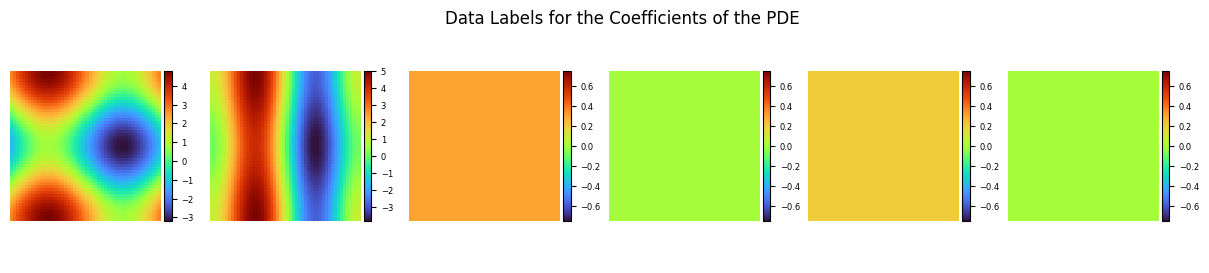

In [8]:
model_list = [model_5,model_7]
coe_label = get_label_coe(max_order=config["max_order"], resolution=config["mesh_size"])
coes_out_dir = os.path.join(config["figure_out_dir"], "coes")
for model in model_list:
    plot_coe(model.coe, coes_out_dir, prefix="coe_trained", step=step, title="Coefficient Regression Results of the PDE")
plot_coe_label(coe_label, coes_out_dir, prefix="coe_label", title="Data Labels for the Coefficients of the PDE")

### Plot Test Error
下图展示了PDE-Net进行长期预测的能力。
- 第一行后的图像两两一组，分别代表[25,50,75]时间步长下kernel_size=5,kernel_size=7的预测情况

[WARNING] MD(33242,7f12171816c0,python):2025-06-16-00:06:51.026.209 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data/eval.mindrecord
[WARNING] MD(33242,7f12171816c0,python):2025-06-16-00:06:51.026.288 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:104] OpenDataFiles] Succeed to remove the old mindrecord metadata files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data/eval.mindrecord.db


Mindrecorder saved
sample 25, MSE Loss 0.0
sample 25, MSE Loss 0.1506546
sample 25, MSE Loss 0.07904634


[WARNING] MD(33242,7f12171816c0,python):2025-06-16-00:07:04.322.152 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data/eval.mindrecord
[WARNING] MD(33242,7f12171816c0,python):2025-06-16-00:07:04.322.211 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:104] OpenDataFiles] Succeed to remove the old mindrecord metadata files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data/eval.mindrecord.db


Mindrecorder saved
sample 50, MSE Loss 0.11759984
sample 50, MSE Loss 0.12416154


[WARNING] MD(33242,7f12171816c0,python):2025-06-16-00:07:08.049.718 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data/eval.mindrecord
[WARNING] MD(33242,7f12171816c0,python):2025-06-16-00:07:08.049.792 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:104] OpenDataFiles] Succeed to remove the old mindrecord metadata files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data/eval.mindrecord.db


Mindrecorder saved
sample 75, MSE Loss 0.46790752
sample 75, MSE Loss 0.38996622


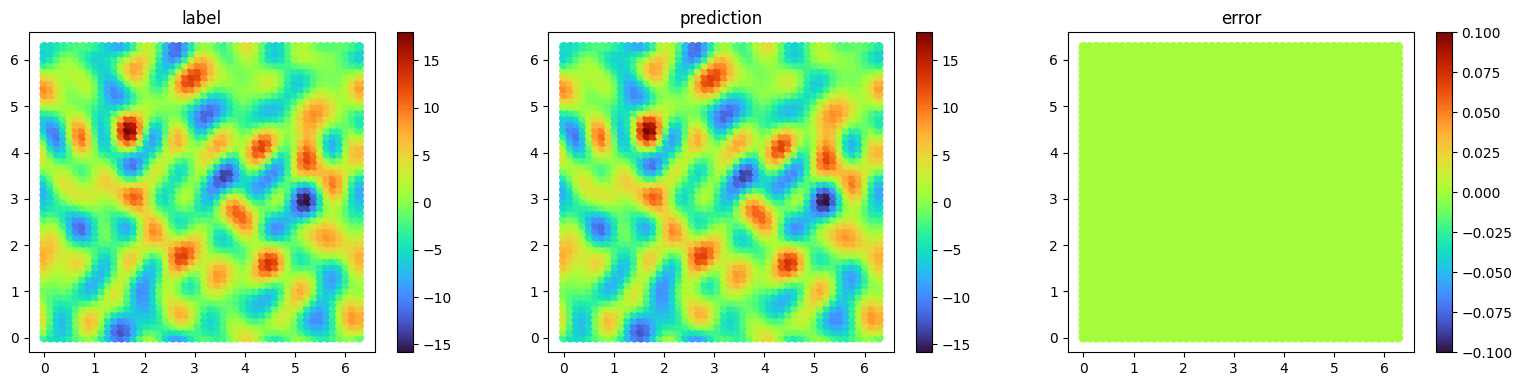

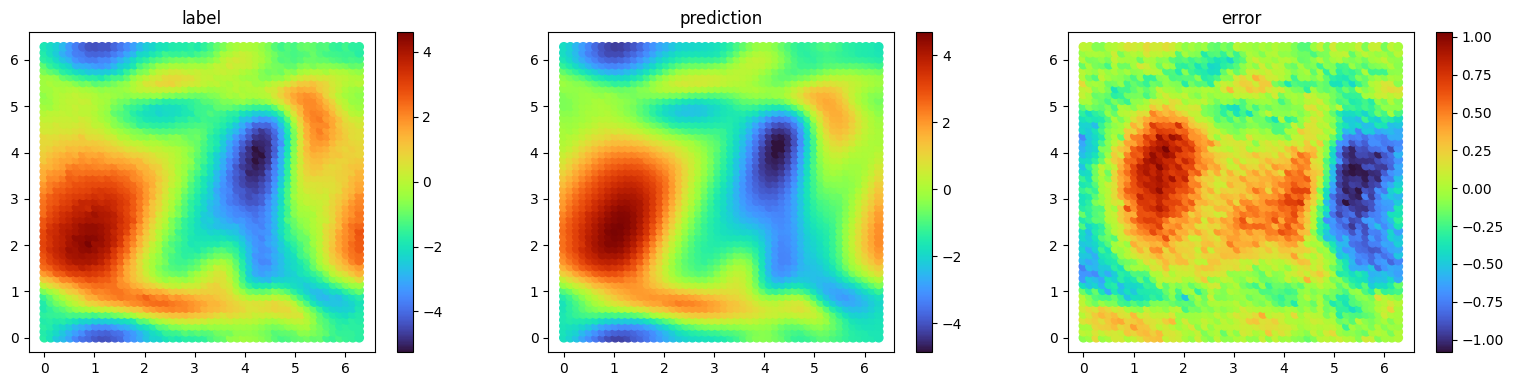

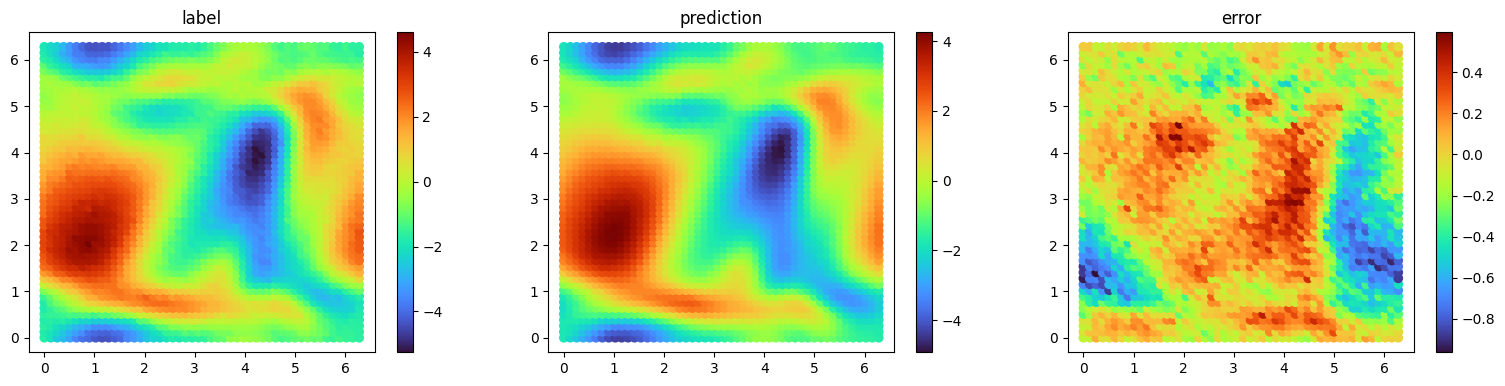

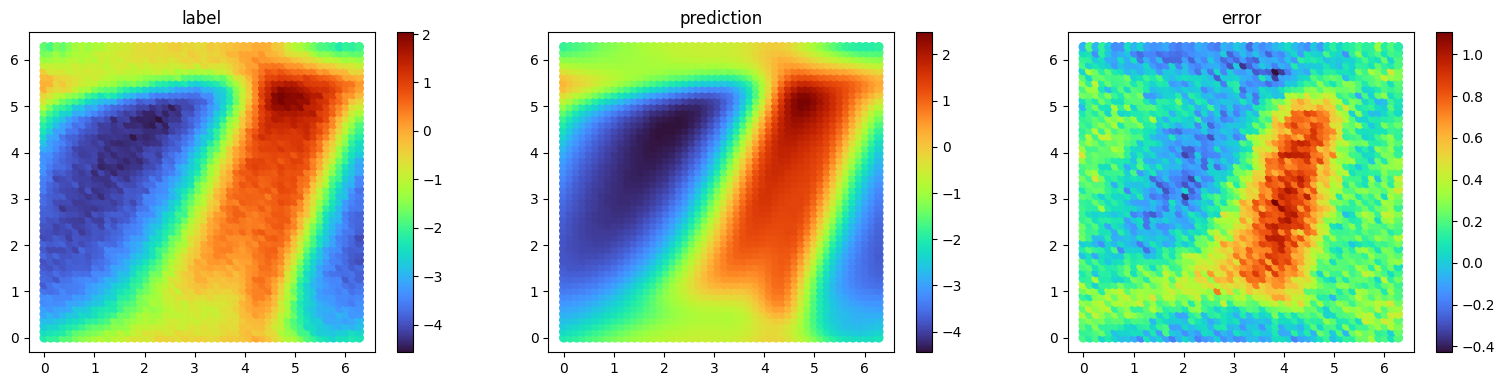

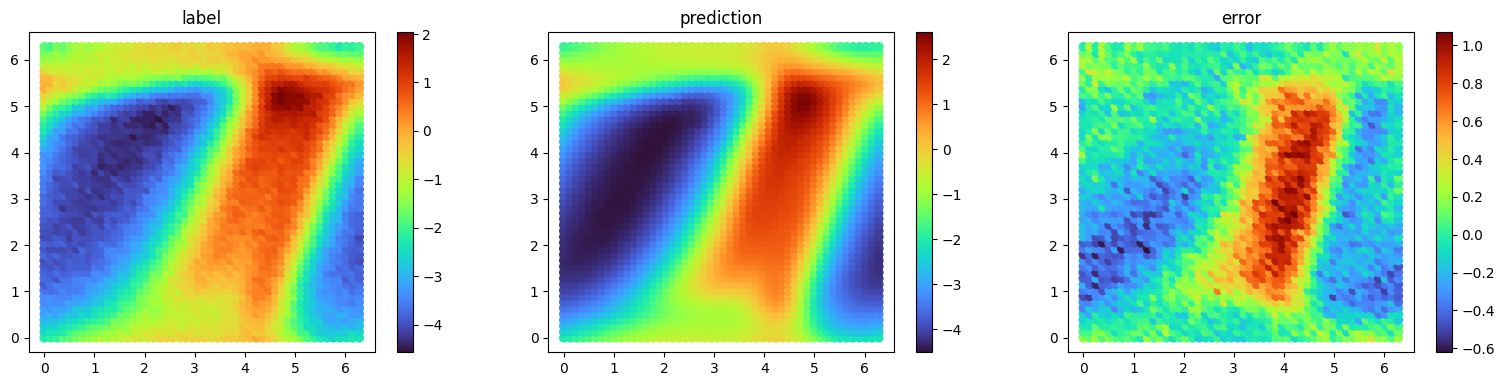

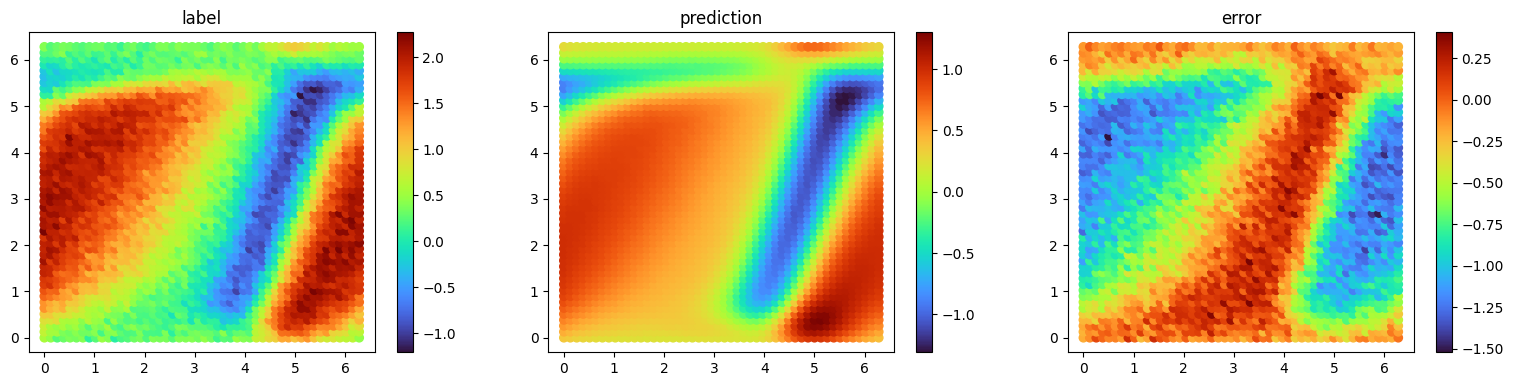

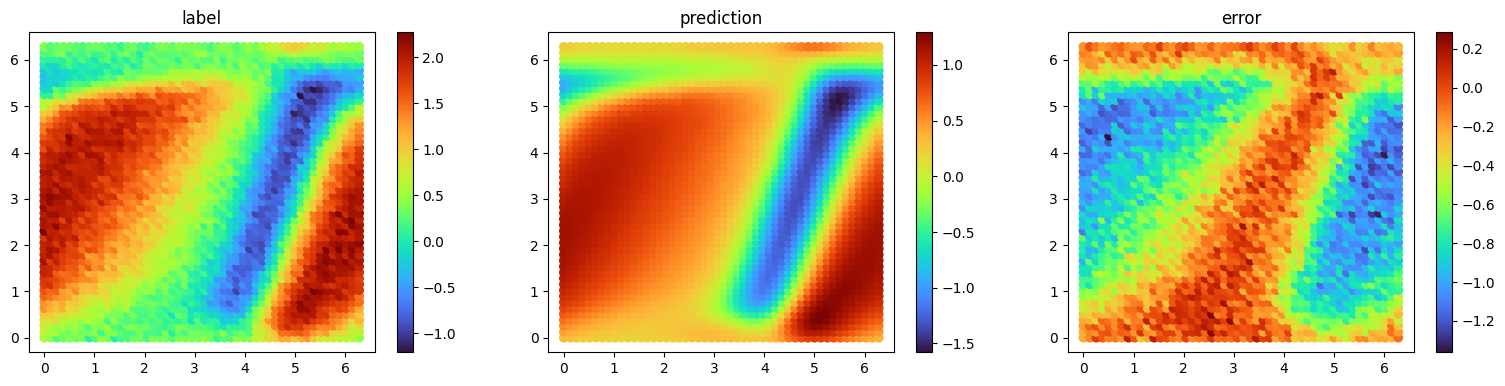

In [9]:


zero_plot_flag = False

for current_step in [25,50,75]:
    dataset = create_dataset(config, current_step, "eval.mindrecord", "test", data_size=1)
    test_dataset = dataset.create_test_dataset(current_step)
    iterator_test_dataset = test_dataset.create_dict_iterator()
    final_item = [_ for _ in iterator_test_dataset][-1]
    for model in model_list:
        problem = UnsteadyFlowWithLoss(model, t_out=current_step, loss_fn=RelativeRMSELoss(), data_format="NTCHW")
        if not zero_plot_flag:
            plot_test_error_0(problem, get_loss_metric("mse"), final_item, current_step, config["mesh_size"], config["figure_out_dir"])
            zero_plot_flag = True
        plot_test_error(problem, get_loss_metric("mse"), final_item, current_step, config["mesh_size"], config["figure_out_dir"])

### Plot Extrapolation Error
不同大小filter的PDE-Net (橙色) 和冻结的PDE-Net(蓝色)在长期预测任务中的预测误差

[WARNING] MD(33242,7f12171816c0,python):2025-06-16-00:38:20.448.124 [mindspore/ccsrc/minddata/mindrecord/io/shard_writer.cc:95] OpenDataFiles] Succeed to remove the old mindrecord files, path: /home/ma-user/work/MindFlow/applications/data_mechanism_fusion/variant_linear_coe_pde_net/data/extrapolation.mindrecord


Mindrecorder saved
step = 1, p25 = 0.06571, p75 = 0.09319
step = 1, p25 = 0.04039, p75 = 0.06140
step = 2, p25 = 0.05536, p75 = 0.09645
step = 2, p25 = 0.05088, p75 = 0.08677
step = 3, p25 = 0.06505, p75 = 0.11790
step = 3, p25 = 0.06013, p75 = 0.10364
step = 4, p25 = 0.07240, p75 = 0.13193
step = 4, p25 = 0.06868, p75 = 0.11620
step = 5, p25 = 0.07828, p75 = 0.14377
step = 5, p25 = 0.07649, p75 = 0.12250
step = 6, p25 = 0.08446, p75 = 0.14809
step = 6, p25 = 0.08012, p75 = 0.12371
step = 7, p25 = 0.09043, p75 = 0.15295
step = 7, p25 = 0.08400, p75 = 0.12648
step = 8, p25 = 0.09302, p75 = 0.15311
step = 8, p25 = 0.08586, p75 = 0.12970
step = 9, p25 = 0.09585, p75 = 0.15244
step = 9, p25 = 0.08584, p75 = 0.13165
step = 10, p25 = 0.09690, p75 = 0.15318
step = 10, p25 = 0.08831, p75 = 0.13375
step = 11, p25 = 0.09639, p75 = 0.15400
step = 11, p25 = 0.09030, p75 = 0.13457
step = 12, p25 = 0.09762, p75 = 0.15620
step = 12, p25 = 0.09167, p75 = 0.13831
step = 13, p25 = 0.09835, p75 = 0.15411

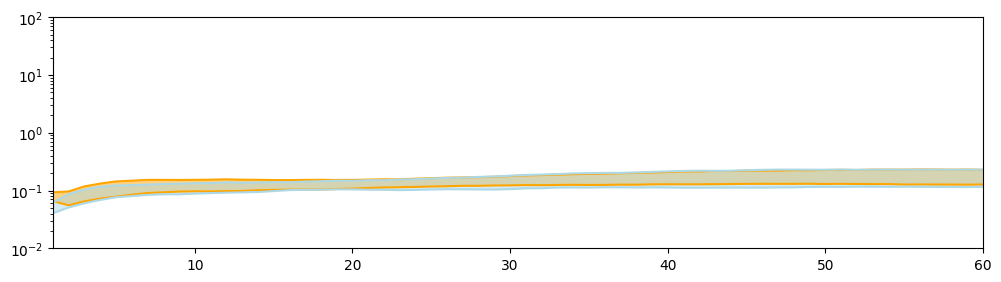

In [12]:
max_step = 60
sample_size = 40
config["summary_dir"] = "./summary_dir/summary_kernel_5"
dataset = create_dataset(config, max_step, "extrapolation.mindrecord", "test", data_size=sample_size)
plot_extrapolation_error(config, param_dict_5,param_dict_5_frozen,dataset, max_step=max_step)